<a href="https://colab.research.google.com/github/philastotle/dissertation-pointnet/blob/master/OrganClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Organ Classifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive

/content/drive


In [6]:
cd My Drive

/content/drive/My Drive


In [7]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [8]:
ls

 DataPreparation.ipynb          my_model_16_16_16.h5
'EDA&PreProcessing.ipynb'       OrganClassifier.ipynb
 keras-test.ipynb               original-voxel-model.ipynb
 Model1_PointNetFull.ipynb      PointNetBasic.ipynb
 Model2_PointNetBasic.ipynb     Py/
 Model3_PointNetBasic_l.ipynb   __pycache__/
 Model4_3DCNN.ipynb             voxel-model.ipynb
 Model5_ANN.ipynb


## Install dependencies

In [9]:
# For Google Colab
!pip install open3d-python

# for reading the ply files 
from open3d import *
import numpy as np

# for 3D visualisation
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# To time 
import time

# For reading the labels
import pandas as pd

    100% |████████████████████████████████| 3.3MB 13.1MB/s 


In [0]:
# Model 1 & 2 - 3140 data with each organ downsampled by points (628 points per organ)

import numpy as np

# farthest point calculation
def calc_distances(p0, points):
    return ((p0 - points)**2).sum(axis=1)

def downsample(pts, K):
    farthest_pts = np.zeros((K, 3))
    farthest_pts[0] = pts[np.random.randint(len(pts))]
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts

# Re-download model that enters another column that specifies if point is PTVHD
def organ_reader(folder, name, points_per_sample, number_of_organs):
    """
    This will read the file directory, list all files, find the patient numbers
    Then for a given patient, load all of their files and merge them into an array
    """
    # dependencies
    import glob
    import os
    from open3d import read_point_cloud
    import numpy as np
    import re
    os.chdir('../1_code')
    os.chdir('../0_data/' + folder)
    # This will read the file directory, list all files, find the patient numbers
    # Then for a given patient, load all of their files and merge them into an array
    # File directory is current
    path = '.'
    files = os.listdir(path)  # lists all files in the current directory
    pt_num = []
    for file in files:
        regex = re.compile(r'\d+')
        # for each file extract the number which corresponds to a patient
        for x in regex.findall(file):
            number = int(x)
            pt_num.append(number)
    # turn that list into a set such that each item in the list is now a patient
    pt_nums = set(pt_num)
    pt_nums = [i for i in pt_nums]
    
    prostates = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
    bladders = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
    femls = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
    femrs = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
    rectums = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
    bodies = np.ndarray(shape=(len(pt_nums), int(points_per_sample/number_of_organs), 4))
        
    
    ############################################################################
    
    for count, patient in enumerate(pt_nums):
        
        print('Importing patient ', patient)
        # Read ply files to point cloud format
        prostate = read_point_cloud('Mesh_PtNum-' + str(patient) + '-PTVHD.ply')
        bladder = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Bladder.ply')
        feml = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadL.ply')
        femr = read_point_cloud('Mesh_PtNum-' + str(patient) + '-FemoralHeadR.ply')
        rectum = read_point_cloud('Mesh_PtNum-' + str(patient) + '-Rectum.ply')
        body = read_point_cloud('Mesh_PtNum-' + str(patient) + '-BODY.ply')

        # Convert point cloud format to cartesian coordinates
        prostate = np.asarray(prostate.points)
        bladder = np.asarray(bladder.points)
        feml = np.asarray(feml.points)
        femr = np.asarray(femr.points)
        rectum = np.asarray(rectum.points)
        body = np.asarray(body.points)
        
        # downsample point cloud
        prostate = downsample(prostate, int(points_per_sample/number_of_organs))
        bladder = downsample(bladder, int(points_per_sample/number_of_organs))
        feml = downsample(feml, int(points_per_sample/number_of_organs))
        femr = downsample(femr, int(points_per_sample/number_of_organs))
        rectum = downsample(rectum, int(points_per_sample/number_of_organs))
        body = downsample(body, int(points_per_sample/number_of_organs))
        
        # Add dimension to signify that prostate is target
        prostate=np.insert(prostate, 3, 0, axis=1)
        bladder=np.insert(bladder, 3, 1, axis=1)
        feml=np.insert(feml, 3, 2, axis=1)
        femr=np.insert(femr, 3, 3, axis=1)
        rectum=np.insert(rectum, 3, 4, axis=1)
        body=np.insert(body, 3, 5, axis=1)
        
        prostates[count] = prostate
        bladders[count] = bladder
        prostates[count] = prostate
        femls[count] = feml
        femrs[count] = femr
        rectums[count] = rectum
        bodies[count] = body

    # Combine them 
    dataset = np.concatenate((prostates,bladders,femls,femrs,rectums, bodies))
        # combined will have shape = (p, 4) where 4 is x,y,z,l
    print("Saving...")
    np.save('../../2_pipeline/' + name + '.npy', dataset)
    
    os.chdir('../../1_code')
    print("Done!")
    
    return dataset

In [0]:
#dataset = organ_reader(folder='prostate-no-nodes', name='organ-classifier-dataset', points_per_sample=3768, number_of_organs=6)

Shuffle data

In [0]:
import os
os.chdir('../../1_code')

In [84]:
dataset = np.load('../2_pipeline/organ-classifier-dataset.npy')
X = dataset[:,:,0:3]
X.shape

(1716, 628, 3)

In [0]:
# Get labels
y = dataset[:,:,-1]
y = y[:,-1]

Load a ply point cloud, print it, and render it


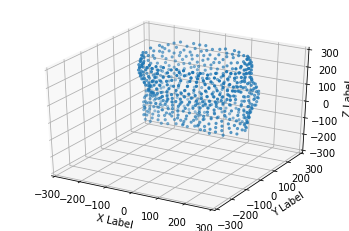

[[ 190.4297   141.7422    -6.     ]
 [-169.0275    54.24219  274.     ]
 [-187.5308   117.5234  -114.     ]
 ...
 [ 150.1953    23.77344  120.     ]
 [-123.6328   216.3516   196.     ]
 [-179.7449   150.3359   -74.     ]]
Cloud shape: (628, 3)


In [98]:
test = X[1711]

print("Load a ply point cloud, print it, and render it")
pcd = read_point_cloud("../2_pipeline/combined.ply")
points = np.asarray(pcd.points)

# plot point cloud 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
	
def plot_ply(file):
  fig = plt.figure()
  ax = fig.add_subplot(111,projection='3d')
  ax.set_ylim(-300,300)
  ax.set_xlim(-300,300)
  ax.set_zlim(-300,300)
  x=file[:,0]
  y=file[:,1]
  z=file[:,2]
  ax.scatter(x, y, z, marker='.', zdir='z')
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

plot_ply(test)
print(test)
print('Cloud shape:', test.shape)

In [0]:
#np.save('../2_pipeline/organ-classifier-X.npy', X)
#np.save('../2_pipeline/organ-classifier-y.npy', y)

Load data and check

## 1. Set seed for reproducibility

In [105]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


## 2. Install dependencies

In [0]:
# Import dependencies
import os
import time
import random
import numpy as np
import tensorflow as tf
from numpy.random import seed
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow import set_random_seed
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, confusion_matrix
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

## 3. Load data

In [113]:
num_points=628
X = np.load('../2_pipeline/organ-classifier-X.npy')
y = np.load('../2_pipeline/organ-classifier-y.npy')

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

Training shape is:  (1097, 628, 3)
Validation shape is:  (275, 628, 3)
Test shape is:  (344, 628, 3)


## 4. Build Model

In [0]:
# hyperparameters

# number of categories
k = 6
# define optimizer
opt = Adam(lr=0.001, decay=0.7)
max_epochs=25
batch_size=32
dropout_rate = 0.7

In [146]:
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(128, 1, activation='relu'))
model.add(Convolution1D(num_points, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(k, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 628, 64)           256       
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 628, 64)           4160      
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 628, 64)           4160      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 628, 128)          8320      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 628, 628)          81012     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 628)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 1, 512)            322048    
__________

## 5. Train & Evaluate

In [149]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs,\
                    shuffle=True, verbose=1, validation_data=(X_val, y_val))

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

Train on 1097 samples, validate on 275 samples
Epoch 1/25
1097/1097 [==============================] - 1s 787us/step - loss: 2.6477 - acc: 0.2142 - val_loss: 1.9329 - val_acc: 0.2436
Epoch 2/25
1097/1097 [==============================] - 1s 793us/step - loss: 2.5064 - acc: 0.2124 - val_loss: 1.9174 - val_acc: 0.2436
Epoch 3/25
1097/1097 [==============================] - 1s 790us/step - loss: 2.5654 - acc: 0.1996 - val_loss: 1.9041 - val_acc: 0.2436
Epoch 4/25
1097/1097 [==============================] - 1s 795us/step - loss: 2.3283 - acc: 0.2005 - val_loss: 1.8908 - val_acc: 0.2436
Epoch 5/25
1097/1097 [==============================] - 1s 796us/step - loss: 2.4502 - acc: 0.2005 - val_loss: 1.8795 - val_acc: 0.2436
Epoch 6/25
1097/1097 [==============================] - 1s 792us/step - loss: 2.4523 - acc: 0.1960 - val_loss: 1.8686 - val_acc: 0.2436
Epoch 7/25
1097/1097 [==============================] - 1s 789us/step - loss: 2.4341 - acc: 0.2106 - val_loss: 1.8576 - val_acc: 0.2436
E

In [134]:
print("\n###################### Model Performance ############################")
# Make predictions 
y_pred = model.predict(X_test)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print("\n#####################################################################")

#Classification report
ann_report = classification_report(y_test, y_pred.round())
print("\nClassfication Report for test:\n", ann_report)
print("\n#####################################################################")



###################### Model Performance ############################

Train: 0.346, Test: 0.358

#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

           0       0.24      1.00      0.39        65
           1       0.15      0.14      0.15        58
           2       0.17      0.83      0.29        48
           3       0.41      0.98      0.58        54
           4       0.19      0.51      0.28        63
           5       0.52      0.61      0.56        56

   micro avg       0.25      0.67      0.37       344
   macro avg       0.28      0.68      0.37       344
weighted avg       0.28      0.67      0.37       344
 samples avg       0.25      0.67      0.36       344


#####################################################################


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.



## 3D CNN Classifier

In [0]:
"""
VoxelGrid Class
"""
import numpy as np
from matplotlib import pyplot as plt
#from ..plot import plot_voxelgrid

class VoxelGrid(object):
    def __init__(self, points, x_y_z=[1, 1, 1], bb_cuboid=True, build=True):
        """
        Parameters
        ----------         
        points: (N,3) ndarray
                The point cloud from which we want to construct the VoxelGrid.
                Where N is the number of points in the point cloud and the second
                dimension represents the x, y and z coordinates of each point.
        
        x_y_z:  list
                The segments in which each axis will be divided.
                x_y_z[0]: x axis 
                x_y_z[1]: y axis 
                x_y_z[2]: z axis

        bb_cuboid(Optional): bool
                If True(Default):   
                    The bounding box of the point cloud will be adjusted
                    in order to have all the dimensions of equal length.                
                If False:
                    The bounding box is allowed to have dimensions of different sizes.
        """
        self.points = points
        xyzmin = np.min(points, axis=0) - 0.001
        xyzmax = np.max(points, axis=0) + 0.001

        if bb_cuboid:
            #: adjust to obtain a  minimum bounding box with all sides of equal lenght 
            diff = max(xyzmax-xyzmin) - (xyzmax-xyzmin)
            xyzmin = xyzmin - diff / 2
            xyzmax = xyzmax + diff / 2
        self.xyzmin = xyzmin
        self.xyzmax = xyzmax

        segments = []
        shape = []

        for i in range(3):
            # note the +1 in num 
            if type(x_y_z[i]) is not int:
                raise TypeError("x_y_z[{}] must be int".format(i))
            s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
            segments.append(s)
            shape.append(step)
        
        self.segments = segments
        self.shape = shape
        self.n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        self.n_x = x_y_z[0]
        self.n_y = x_y_z[1]
        self.n_z = x_y_z[2]
        self.id = "{},{},{}-{}".format(x_y_z[0], x_y_z[1], x_y_z[2], bb_cuboid)
        if build:
            self.build()

    def build(self):
        structure = np.zeros((len(self.points), 4), dtype=int)
        structure[:,0] = np.searchsorted(self.segments[0], self.points[:,0]) - 1
        structure[:,1] = np.searchsorted(self.segments[1], self.points[:,1]) - 1
        structure[:,2] = np.searchsorted(self.segments[2], self.points[:,2]) - 1
        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * self.n_x) + structure[:,0]) + (structure[:,2] * (self.n_x * self.n_y)) 
        
        self.structure = structure
        vector = np.zeros(self.n_voxels)
        count = np.bincount(self.structure[:,3])
        vector[:len(count)] = count
        self.vector = vector.reshape(self.n_z, self.n_y, self.n_x)

 
    def plot(self, d=2, cmap="Oranges", axis=False):

        if d == 2:
            fig, axes= plt.subplots(int(np.ceil(self.n_z / 4)), 4, figsize=(8,8))
            plt.tight_layout()
            for i,ax in enumerate(axes.flat):
                if i >= len(self.vector):
                    break
                im = ax.imshow(self.vector[i], cmap=cmap, interpolation="none")
                ax.set_title("Level " + str(i))
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label('NUMBER OF POINTS IN VOXEL')
        elif d == 3:
            return plot_voxelgrid(self, cmap=cmap, axis=axis)



In [0]:
# batch voxelise the data
def data_importer(data_points, h, w, d):
    # create empty array with dimensions n * (16*16*16)
    points = np.zeros((data_points.shape[0],(h*w*d)), dtype=float)
    #import all files
    for num in range(0,data_points.shape[0]): 
        # get xyz points from file
        tmp = data_points[num]
        #tmp = scale(tmp, -1, 1)
        tmp = VoxelGrid(tmp, x_y_z=[h,w,d])
        # get vector array of voxel
        tmp = tmp.vector
        #flatten vector
        tmp = np.concatenate(tmp).ravel()
        # add to our list
        points[num] = tmp
    return points

In [0]:
h,w,d = 16,16,16
X = data_importer(X, h,w,d)
# Save the data
np.save('../2_pipeline/organ-classifier-voxels.npy', X)

In [223]:
size = 16
h,w,d = size,size,size

X = np.load('../2_pipeline/organ-classifier-voxels.npy')
y = np.load('../2_pipeline/organ-classifier-y.npy')

#split the data
print("Splitting the data...")
from sklearn.model_selection import train_test_split
#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

# Check train and test size
print("X training size is: ", X_train.shape)
print("y training size is: ", y_train.shape)
print("\nX val size is: ", X_val.shape)
print("y val size is: ", y_val.shape)
print("\nX test size is: ", X_test.shape)
print("y test size is: ", y_test.shape)

print("Preprocessing the data...")
## Introduce the channel dimension in the input dataset 
xtrain = np.ndarray((X_train.shape[0], (h*w*d), 3))
xval = np.ndarray((X_val.shape[0], (h*w*d), 3))
xtest = np.ndarray((X_test.shape[0], (h*w*d), 3))

# Translate data to color by iterating through train and test and
# adding a colour dimension
from matplotlib.pyplot import cm

def add_rgb_dimension(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(X_train.shape[0]):
    xtrain[i] = add_rgb_dimension(X_train[i])
for i in range(X_val.shape[0]):
    xval[i] = add_rgb_dimension(X_val[i])
for i in range(X_test.shape[0]):
    xtest[i] = add_rgb_dimension(X_test[i])
    
## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
x_train = xtrain.reshape(X_train.shape[0], h, w, d, 3)
x_val = xval.reshape(X_val.shape[0], h, w, d, 3)
x_test = xtest.reshape(X_test.shape[0], h, w, d, 3)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Splitting the data...
X training size is:  (1097, 4096)
y training size is:  (1097,)

X val size is:  (275, 4096)
y val size is:  (275,)

X test size is:  (344, 4096)
y test size is:  (344,)
Preprocessing the data...


## 4. Build 3D CNN
Lets create the model architecture. The architecture is described below:

Input and Output layers:

* One Input layer with dimentions 16, 16, 16, 3
* Output layer with dimensions 2

Convolutions :
* Apply 4 Convolutional layer with increasing order of filter size (standard size : 8, 16, 32, 64) and fixed kernel size = (3, 3, 3)
* Apply 2 Max Pooling layers, one after 2nd convolutional layer and one after fourth convolutional layer.

MLP architecture:
* Batch normalization on convolutiona architecture
* Dense layers with 2 layers followed by dropout to avoid overfitting

In [0]:
# Install depedencies
from keras.models import Sequential
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
from mlxtend.plotting import plot_confusion_matrix
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, SGD, Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

In [225]:
# Hyper parameters
max_epochs = 250
batch_size = 128
#opt = Adadelta(lr=0.001)
opt = Adam(lr=0.01, decay=0.7)
dropout_rate=0.2

#from keras.optimizers import SGD
#opt = SGD(lr=0.001, momentum=0.9)

model = Sequential()
# Convolution layers
model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', input_shape=(h, w, d, 3)))
model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu'))
# Add max pooling to obtain the most informatic features
model.add(MaxPool3D(pool_size=(2, 2, 2)))

# Convolution layers
model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
# Add max pooling to obtain the most informatic features
model.add(MaxPool3D(pool_size=(2, 2, 2)))

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
model.add(BatchNormalization())
model.add(Flatten())

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
model.add(Dense(units=(h*w*d), activation='relu'))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(units=k, activation='sigmoid'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 1, 1, 1, 64)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 1, 1, 64)       256       
__________

## Train & Evaluate

In [226]:
print("\n####################### Training Model ##############################")
print("Training...")
history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(x_val, y_val), verbose=1)


####################### Training Model ##############################
Training...
Train on 1097 samples, validate on 275 samples
Epoch 1/250
1097/1097 [==============================] - 4s 3ms/step - loss: 1.2233 - acc: 0.6664 - val_loss: 8.7771 - val_acc: 0.3200
Epoch 2/250
1097/1097 [==============================] - 0s 256us/step - loss: 0.7170 - acc: 0.8669 - val_loss: 8.7985 - val_acc: 0.3055
Epoch 3/250
1097/1097 [==============================] - 0s 246us/step - loss: 0.6399 - acc: 0.8633 - val_loss: 9.0846 - val_acc: 0.3164
Epoch 4/250
1097/1097 [==============================] - 0s 239us/step - loss: 0.6023 - acc: 0.8624 - val_loss: 6.8577 - val_acc: 0.4182
Epoch 5/250
1097/1097 [==============================] - 0s 241us/step - loss: 0.5689 - acc: 0.8578 - val_loss: 4.6756 - val_acc: 0.2836
Epoch 6/250
1097/1097 [==============================] - 0s 242us/step - loss: 0.5469 - acc: 0.8642 - val_loss: 4.2918 - val_acc: 0.2800
Epoch 7/250
1097/1097 [===========================

In [229]:
print("\n###################### Model Performance ############################")
# Make predictions 
y_pred = model.predict(x_test)

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print("\n#####################################################################")

#Classification report
report = classification_report(y_test, y_pred.round(), target_names=['Prostate', 'Bladder', 'Left Fem', 'Right Fem', 'Rectum', 'Body'])
print("\nClassfication Report for test:\n", report)
print("\n#####################################################################")


###################### Model Performance ############################

Train: 0.987, Test: 0.977

#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

    Prostate       0.93      0.98      0.96        65
     Bladder       0.47      1.00      0.64        58
    Left Fem       1.00      0.94      0.97        48
   Right Fem       0.98      0.98      0.98        54
      Rectum       0.97      1.00      0.98        63
        Body       0.95      1.00      0.97        56

   micro avg       0.82      0.99      0.89       344
   macro avg       0.88      0.98      0.92       344
weighted avg       0.88      0.99      0.92       344
 samples avg       0.88      0.99      0.92       344


#####################################################################


Example

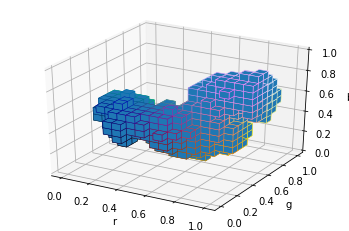

In [228]:
example = X_test[0]
example = example.reshape(16,16,16)

import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(r, g, b, example,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b')

plt.show()

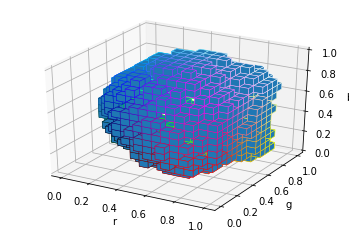

In [202]:
example2 = X_test[1]
example2 = example2.reshape(16,16,16)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(r, g, b, example2,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b')

plt.show()

In [199]:
y_pred = model.predict(x_test[0:2,:,:])
y_pred.round()[0]
y_pred.round()[1]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
test = np.array(([1,2,3],[4,5,6]))

In [217]:
test = test.reshape(2,3,1)
test

array([[[1],
        [2],
        [3]],

       [[4],
        [5],
        [6]]])

In [216]:
test.shape

(2, 3, 1)